In [1]:
import imp
import os
import logging

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly

from BuildingControlsSimulator.Simulator.Simulation import Simulation
from BuildingControlsSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlsSimulator.BuildingModels.EnergyPlusBuildingModel import EnergyPlusBuildingModel
from BuildingControlsSimulator.ControlModels.Deadband import Deadband

plotly.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2


In [2]:
s = Simulation(
    building_model=EnergyPlusBuildingModel(
        idf=IDFPreprocessor(
            idf_file="SF+CZ2B+USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780+gasfurnace+crawlspace+IECC_2018.idf",
            init_temperature=21.),
        weather_file="USA_AZ_Phoenix-Sky.Harbor.Intl.AP.722780_TMY3.epw"
    ),
    controller_model=Deadband(deadband=2., stp_heat=21., stp_cool=24.),
    step_size_minutes=5,
    start_time_days = 204,
    final_time_days = 209,
)

In [3]:
%%time
s.create_models(preprocess_check=True)

CPU times: user 308 ms, sys: 15.1 ms, total: 323 ms
Wall time: 18.8 s


'/home/bcs/lib/building-controls-simulator/fmu/v8-9-0/SF_CZ2B_USA_AZ_Phoenix_Sky_Harbor_Intl_AP_722780_gasfurnace_crawlspace_IECC_2018_prep.fmu'

In [4]:
%%time
output_df = s.run()

CPU times: user 1.76 s, sys: 330 ms, total: 2.09 s
Wall time: 26 s


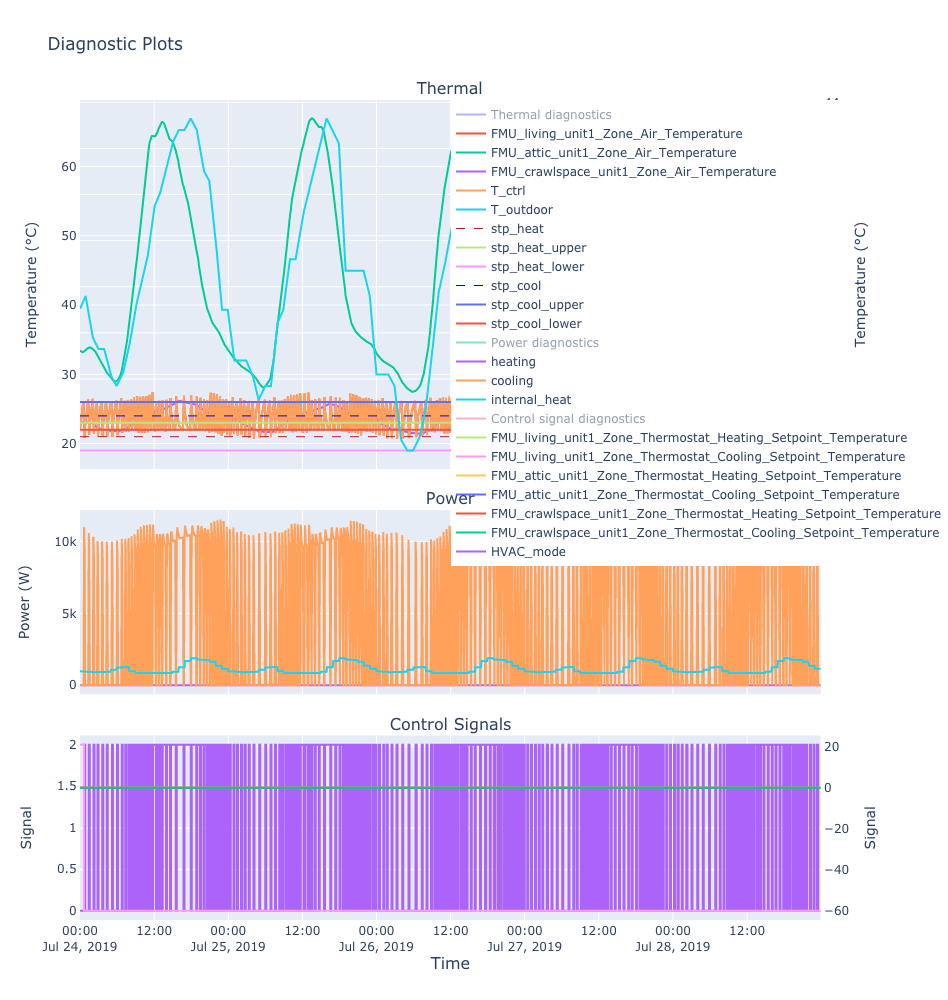

CPU times: user 2.36 s, sys: 33.8 ms, total: 2.39 s
Wall time: 2.43 s


In [5]:
%%time
s.show_plots()

In [6]:
output_df

,time_seconds,step_status,t_ctrl,HVAC_mode,stp_heat,stp_cool,deadband,FMU_T_heating_stp,FMU_T_cooling_stp,FMU_T_control_type,...,FMU_crawlspace_unit1_Zone_Air_Temperature,FMU_crawlspace_unit1_Zone_Thermostat_Heating_Setpoint_Temperature,FMU_crawlspace_unit1_Zone_Thermostat_Cooling_Setpoint_Temperature,FMU_crawlspace_unit1_Zone_Air_System_Sensible_Heating_Rate,FMU_crawlspace_unit1_Zone_Air_System_Sensible_Cooling_Rate,FMU_crawlspace_unit1_Zone_Total_Internal_Total_Heating_Rate,datetime,total_heating,total_cooling,total_internal_gains
0,17625600,0,22.123612,0,21.0,24.0,2.0,0.0,0.0,0.0,...,23.203617,0.0,0.0,0.0,0.0,0.0,2019-07-24 00:00:00,0.0,0.0,972.807796
1,17625900,0,22.863755,0,21.0,24.0,2.0,0.0,0.0,0.0,...,23.176362,0.0,0.0,0.0,0.0,0.0,2019-07-24 00:05:00,0.0,0.0,972.807796
2,17626200,0,23.491635,0,21.0,24.0,2.0,0.0,0.0,0.0,...,23.153889,0.0,0.0,0.0,0.0,0.0,2019-07-24 00:10:00,0.0,0.0,972.807796
3,17626500,0,23.998466,0,21.0,24.0,2.0,0.0,0.0,0.0,...,23.135677,0.0,0.0,0.0,0.0,0.0,2019-07-24 00:15:00,0.0,0.0,972.807796
4,17626800,0,25.000260,0,21.0,24.0,2.0,0.0,0.0,0.0,...,23.110402,0.0,0.0,0.0,0.0,0.0,2019-07-24 00:20:00,0.0,0.0,972.807796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,18056100,0,23.592133,0,21.0,24.0,2.0,0.0,0.0,0.0,...,22.027083,0.0,0.0,0.0,0.0,0.0,2019-07-28 23:35:00,0.0,0.0,1142.401706
1436,18056400,0,24.275271,0,21.0,24.0,2.0,0.0,0.0,0.0,...,22.025137,0.0,0.0,0.0,0.0,0.0,2019-07-28 23:40:00,0.0,0.0,1142.401706
1437,18056700,0,24.794057,0,21.0,24.0,2.0,0.0,0.0,0.0,...,22.024959,0.0,0.0,0.0,0.0,0.0,2019-07-28 23:45:00,0.0,0.0,1142.401706
1438,18057000,0,25.772218,0,21.0,24.0,2.0,0.0,0.0,0.0,...,22.026244,0.0,0.0,0.0,0.0,0.0,2019-07-28 23:50:00,0.0,0.0,1142.401706


In [7]:
hvac_df = output_df[["time_seconds", "HVAC_mode"]].copy(deep=True)
hvac_df["HVAC_mode_prev"] = hvac_df.HVAC_mode.shift(periods=1)
hvac_mode_changes = hvac_df[hvac_df.HVAC_mode_prev != hvac_df.HVAC_mode].copy(deep=True)
hvac_mode_changes["time_seconds_prev"] = hvac_mode_changes.time_seconds.shift(periods=1)
hvac_mode_changes["time_delta"] = hvac_mode_changes["time_seconds"] - hvac_mode_changes["time_seconds_prev"]

total runtime (s): 192900.0
mean HVAC on-cycle length (s): 1004.6875


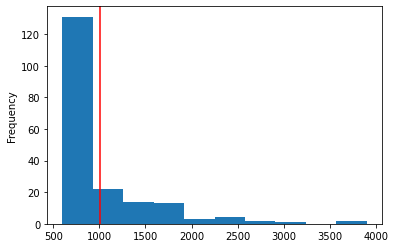

In [8]:
on_cycles = hvac_mode_changes[hvac_mode_changes.HVAC_mode == 0].time_delta
plt = on_cycles.plot.hist()
plt.axvline(x=on_cycles.mean(), color='r')
print("total runtime (s): {}".format(on_cycles.sum()))
print("mean HVAC on-cycle length (s): {}".format(on_cycles.mean()))

mean HVAC off-cycle length: 1235.9375


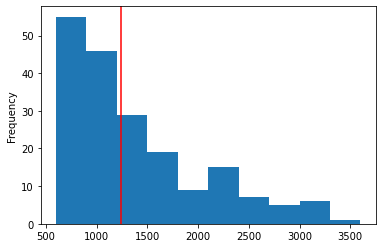

In [9]:
off_cycles = hvac_mode_changes[hvac_mode_changes.HVAC_mode == 2].time_delta
plt = off_cycles.plot.hist()
plt.axvline(x=off_cycles.mean(), color='r')
print("mean HVAC off-cycle length: {}".format(off_cycles.mean()))